<a href="https://colab.research.google.com/github/karumanchi/project2020/blob/master/trading_framework_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install yfinance
! pip install ta

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=0e7af5949272ef0135592fa9279c32694536dbead6b400779cfdeb312673f392
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance
  Created wheel for ta: filename=ta-0.5.25-cp36-none-any.whl size=24880 sha256=848c196398885acf2d3010c0c62cca462942077ad07476728237545f9fbbc7e7
  Stored in directory: /root/.cache/pip/wheels/2e/93/b7/cf649194508e53cee4145ffb949e9f26877a5a8dd12db9ed5b
Successfully built ta


In [ ]:
import yfinance as yf
import ta
import pandas as pd
from datetime import timedelta, date, datetime


In [ ]:
ticker = 'TSLA' #'ISF.L'
start_date = '2019-01-01'
end_date = '2020-07-20'
date_fmt = '%Y-%m-%d'

[*********************100%***********************]  1 of 1 completed


,CUM_RET,BUY_HOLD,ZERO
Date,,,
2020-07-20,-96.81,431.5,0


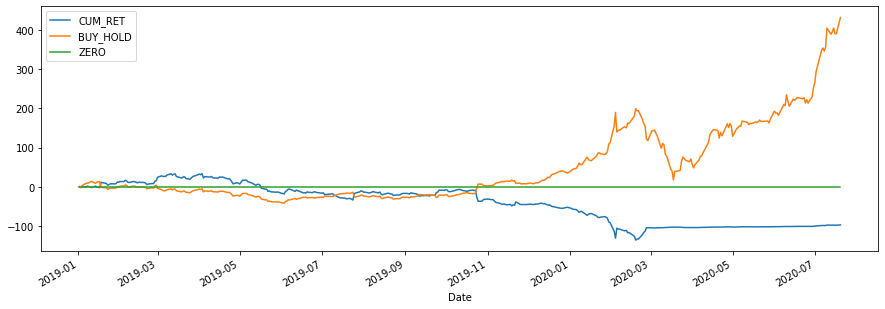

In [ ]:
start_date_buffer = datetime.strptime(start_date,date_fmt) - timedelta(days = 365)
start_date_buffer = start_date_buffer.strftime(date_fmt)

###
df = yf.download(ticker, start = start_date_buffer, end_date = end_date)
df.head()

##
k_band = ta.volatility.KeltnerChannel(df.High, df.Low, df.Close, 10,10)
df['K_BAND_UB'] = k_band.keltner_channel_hband().round(4)
df['K_BAND_LB'] = k_band.keltner_channel_lband().round(4)
df[['K_BAND_UB','K_BAND_LB']].dropna().head()

##
df['CLOSE_PREV'] = df.Close.shift(1)
df['LONG'] = (df.Close <= df.K_BAND_LB) & (df.CLOSE_PREV > df.K_BAND_LB)
df['EXIT_LONG'] = (df.Close >= df.K_BAND_UB) & (df.CLOSE_PREV < df.K_BAND_UB)

df['SHORT'] = (df.Close >= df.K_BAND_UB) & (df.CLOSE_PREV < df.K_BAND_UB) 
df['EXIT_SHORT'] = (df.Close <= df.K_BAND_LB) & (df.CLOSE_PREV > df.K_BAND_LB)

##
df.LONG = df.LONG.shift(1)
df.EXIT_LONG = df.EXIT_LONG.shift(1)
df.SHORT = df.SHORT.shift(1)
df.EXIT_SHORT = df.EXIT_SHORT.shift(1)
df[['LONG', 'EXIT_LONG', 'SHORT','EXIT_SHORT']].dropna().head()

##
bt_df = df[(df.index >= start_date) & (df.index <=end_date)]
bt_df.head()

##
balance = 1000000
pnl = 0
position = 0

last_signal = 'hold'
last_price = 0
c =0

trade_date_start = []
trade_date_end = []
trade_days = []
trade_side = []
trade_pnl=[]
trade_ret=[]
cum_value = []


for index, row in bt_df.iterrows():
  #chk and close position
  if row.EXIT_LONG and last_signal == 'long':
    trade_date_end.append(row.name)
    trade_days.append(c)
    pnl = (row.Open - last_price)*position
    trade_pnl.append(pnl)
    trade_ret.append((row.Open/last_price -1)*100)
    balance += row.Open *position
    position = 0
    last_signal = 'hold'
    c =0

  elif row.EXIT_SHORT and last_signal == 'short':
    trade_date_end.append(row.name)
    trade_days.append(c)
    pnl = (row.Open - last_price)*position
    trade_pnl.append(pnl)
    trade_ret.append((last_price/row.Open -1)*100)
    balance += pnl
    position = 0
    last_signal = 'hold'
    c =0

  #chk signal and enter poss postn
  if row.LONG and last_signal != 'long':
    last_signal = 'long'
    last_price = row.Open
    trade_date_start.append(row.name)
    trade_side.append('long')
    position = int(balance / row.Open)
    cost = position * row.Open
    balance = balance - cost
    c=0

  elif row.SHORT and last_signal != 'short':
    last_signal = 'short'
    last_price = row.Open
    trade_date_start.append(row.name)
    trade_side.append('short')
    position = int(balance / row.Open)*-1
    c=0

  # Compute mkt value and count days for any poss position
  if last_signal == 'hold':
    market_value = balance
  elif last_signal == 'long':
    c = c+1
    market_value = position *row.Close + balance
  else:
    c = c+1
    market_value = (row.Close - last_price)*position + balance
  cum_value.append(market_value)

##
cum_ret_df = pd.DataFrame(cum_value, index = bt_df.index, columns = ['CUM_RET'])
cum_ret_df['CUM_RET'] = (cum_ret_df.CUM_RET/1000000 -1)*100
cum_ret_df['BUY_HOLD'] = (bt_df.Close/ bt_df.Open.iloc[0] -1)*100
cum_ret_df['ZERO'] =0
cum_ret_df.plot(figsize=(15,5))
cum_ret_df.iloc[[-1]].round(2)

